In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
from src.utils import pathsetup, split_by_trials
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.linear_model

from src.worldModels import *
from src.utils import *
from src.run_simulations import *
from src.agents import *
from tqdm.notebook import tqdm

import pickle

%matplotlib inline

%reload_ext autoreload
%autoreload 2


In [5]:
# Simulating the behavior of agents along the eps-gamma axis
epslst = [0.1, 0.1, 0.1]
# [0.2, 0.5, 0.45] works well
gammalst = [0.2, 0.5, 0.47]
rlow = 0.1
rhigh = 0.9
ntrials_per_block = [20, 20]

simtype = 'qlearning'
Tmax = 6
Niter = 1

choicelst_all = []
params_all = []
pfits = []
coefs_all = []
perf_train_all = []
perf_test_all = []

agents = []
worlds = []
for i in tqdm(range(len(epslst))):
    if i == 2:
        params = dict(N_iters=50, num_states=2, obs_dim=1, nblocks=2000,
                 eps=0, hmm_fit=False, sigmoid_window=30,
                 ntrials_per_block=ntrials_per_block, gammalst=[gammalst[i]], epslst=[epslst[i]],
                 rlow=rlow, rhigh=rhigh, type=simtype)
    else:
        params = dict(N_iters=50, num_states=2, obs_dim=1, nblocks=1000,
                 eps=0, hmm_fit=False, sigmoid_window=30,
                 ntrials_per_block=ntrials_per_block, gammalst=[gammalst[i]], epslst=[epslst[i]],
                 rlow=rlow, rhigh=rhigh, type=simtype)
    print(params['nblocks'])
    
    np.random.seed(124)
    
    agent, world, _, _, _ = run_single_agent(0, 0, params)
    
    agents.append(agent)
    worlds.append(world)

    choicelst = split_by_trials(agent.outcome_history, world.ntrialblocks[:-1], chop='max')
#     choicelst[1::2] = 1 - choicelst[1::2]

    # Fit a simgoidal curve
    average = np.nanmean(choicelst, axis=0)
    pfit = fit_doublesigmoid_helper(average, 1 - average)
    pfits.append(pfit)
    
    
    params_all.append(params)
    choicelst_all.append(choicelst)
    
# extract only the offset, slope, lapse    
pfits = np.array(pfits)[:, [0, 1, 4]]
    

  0%|          | 0/3 [00:00<?, ?it/s]

1000
1000
2000


In [6]:
choicelst0 = split_by_trials(agents[0].choice_history, worlds[0].ntrialblocks[:-1], chop='max')
choicelst1 = split_by_trials(agents[1].choice_history, worlds[1].ntrialblocks[:-1], chop='max')
choicelst2 = split_by_trials(agents[2].choice_history, worlds[2].ntrialblocks[:-1], chop='max')

outcomelst0 = split_by_trials(agents[0].outcome_history, worlds[0].ntrialblocks[:-1], chop='max')
outcomelst1 = split_by_trials(agents[1].outcome_history, worlds[1].ntrialblocks[:-1], chop='max')
outcomelst2 = split_by_trials(agents[2].outcome_history, worlds[2].ntrialblocks[:-1], chop='max')

# scale to -1/1
choicelst0 = choicelst0 * 2 - 1
choicelst1 = choicelst1 * 2 - 1
choicelst2 = choicelst2 * 2 - 1

outcomelst0 = outcomelst0 * 2 - 1
outcomelst1 = outcomelst1 * 2 - 1
outcomelst2 = outcomelst2 * 2 - 1

# concat lst 0 and lst1
outcomelstA = np.vstack([outcomelst0, outcomelst1])
choicelstA = np.vstack([choicelst0, choicelst1])


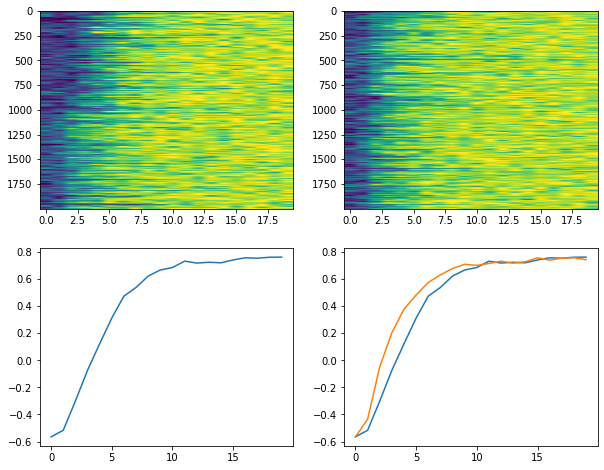

In [7]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(outcomelstA, aspect='auto')

plt.subplot(222)
plt.imshow(outcomelst2, aspect='auto')

plt.subplot(223)
plt.plot(np.mean(outcomelstA, axis=0))

plt.subplot(224)
plt.plot(np.mean(outcomelstA, axis=0))
plt.plot(np.mean(outcomelst2, axis=0))


# plt.subplot(133)
# plt.imshow(choicelst_all[2], aspect='auto')

In [8]:
def unfold_block(choices, outcomes):
    '''
    Given a block, unfold into three flattened arrays:
    choices, outcomes, choices x outcomes
    
    '''
    choices_flat = np.reshape(choices, (-1, 1))
    outcomes_flat = np.reshape(outcomes, (-1, 1))
    choices_flat = choices_flat[~np.isnan(choices_flat)]
    outcomes_flat = outcomes_flat[~np.isnan(outcomes_flat)]
    
    return choices_flat, outcomes_flat

def make_Xy(choices, outcomes, N=1):
    '''
    block: raw data block, of shape Nblocks x trials
    N: number of trials back in the past to extract for the regression
    Returns:
    Xmat: Xmatrix of shape (Nblocks x trials - 3N) x (3N),
    arranged as blocks of [choice history; outcome history; choice x outcome history]
    in each block there are N columns, corresponding to (t-N, ..., t-2, t-1)
    y: y vector, the choice
    
    '''
    choices_flat, outcomes_flat = unfold_block(choices, outcomes)
    outcomesXchoices = choices_flat * outcomes_flat
    
    y = choices_flat[N:].ravel()
    
    choicehistory = []
    outcomehistory = []
    choiceoutcomehistory = []
    
    for i in range(N):  
        X1 = choices_flat[i:-N+i]
        X2 = outcomes_flat[i:-N+i]
        X3 = outcomesXchoices[i:-N+i]
        choicehistory.append(X1)
        outcomehistory.append(X2)
        choiceoutcomehistory.append(X3)
    
#     print(choicehistory[0].shape, outcomehistory[0].shape, choiceoutcomehistory[0].shape)
#     print(len(choicehistory), len(outcomehistory), len(choiceoutcomehistory))
#     print(len(choicehistory + outcomehistory + choiceoutcomehistory))
    Xmat = np.vstack(choicehistory + outcomehistory + choiceoutcomehistory)
    
    return choicehistory, outcomehistory, choiceoutcomehistory, Xmat.T, y

In [20]:
y1.shape

(39985,)

In [21]:
np.sum(y1)

191.0

In [24]:
y1.shape

(39985,)

In [30]:
Nmax = 15
_, _, _, Xmat1, y1 = make_Xy(choicelstA, outcomelstA, N=Nmax)
_, _, _, Xmat2, y2 = make_Xy(choicelst2, outcomelst2, N=Nmax)

mdl1 = sklearn.linear_model.LogisticRegression()
mdl1.fit(Xmat1, y1)

mdl2 = sklearn.linear_model.LogisticRegression()
mdl2.fit(Xmat2, y2)



LogisticRegression()

2.3472314179517836e-05


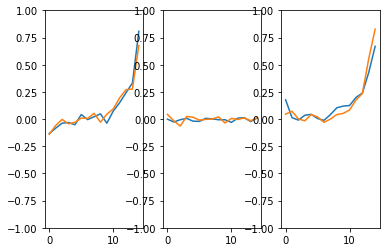

In [31]:
# for gamma = 0.45
yrange = [-1, 1]
plt.subplot(131)
plt.plot(mdl1.coef_[0][:Nmax]);
plt.plot(mdl2.coef_[0][:Nmax]);
# plt.plot(mdl3.coef_[0][:10]);
plt.ylim([-1, 1])

plt.subplot(132)
plt.plot(mdl1.coef_[0][Nmax:2*Nmax]);
plt.plot(mdl2.coef_[0][Nmax:2*Nmax]);
# plt.plot(mdl3.coef_[0][10:20]);
plt.ylim([-1, 1])

plt.subplot(133)
coefs1 = mdl1.coef_[0][2*Nmax:]
coefs2 = mdl2.coef_[0][2*Nmax:]
plt.plot(mdl1.coef_[0][2*Nmax:]);
plt.plot(mdl2.coef_[0][2*Nmax:]);
# plt.plot(mdl3.coef_[0][10:20]);
plt.ylim([-1, 1])

print(np.mean(coefs1 - coefs2)**2)



2.3472314179517836e-05


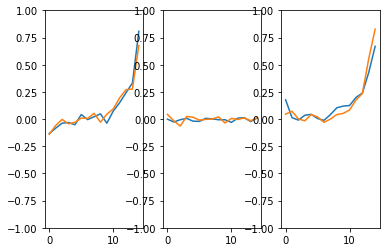

In [116]:
# for gamma = 0.47
yrange = [-1, 1]
plt.subplot(131)
plt.plot(mdl1.coef_[0][:Nmax]);
plt.plot(mdl2.coef_[0][:Nmax]);
# plt.plot(mdl3.coef_[0][:10]);
plt.ylim([-1, 1])

plt.subplot(132)
plt.plot(mdl1.coef_[0][Nmax:2*Nmax]);
plt.plot(mdl2.coef_[0][Nmax:2*Nmax]);
# plt.plot(mdl3.coef_[0][10:20]);
plt.ylim([-1, 1])

plt.subplot(133)
coefs1 = mdl1.coef_[0][2*Nmax:]
coefs2 = mdl2.coef_[0][2*Nmax:]
plt.plot(mdl1.coef_[0][2*Nmax:]);
plt.plot(mdl2.coef_[0][2*Nmax:]);
# plt.plot(mdl3.coef_[0][10:20]);
plt.ylim([-1, 1])

print(np.mean(coefs1 - coefs2)**2)



0.00011394657890653925


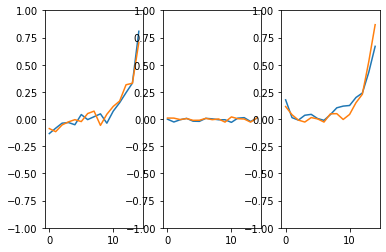

In [123]:
# for gamma = 0.48
yrange = [-1, 1]
plt.subplot(131)
plt.plot(mdl1.coef_[0][:Nmax]);
plt.plot(mdl2.coef_[0][:Nmax]);
# plt.plot(mdl3.coef_[0][:10]);
plt.ylim([-1, 1])

plt.subplot(132)
plt.plot(mdl1.coef_[0][Nmax:2*Nmax]);
plt.plot(mdl2.coef_[0][Nmax:2*Nmax]);
# plt.plot(mdl3.coef_[0][10:20]);
plt.ylim([-1, 1])

plt.subplot(133)
coefs1 = mdl1.coef_[0][2*Nmax:]
coefs2 = mdl2.coef_[0][2*Nmax:]
plt.plot(mdl1.coef_[0][2*Nmax:]);
plt.plot(mdl2.coef_[0][2*Nmax:]);
# plt.plot(mdl3.coef_[0][10:20]);
plt.ylim([-1, 1])

print(np.mean(coefs1 - coefs2)**2)



In [13]:
# Save data
paths = pathsetup('matchingsim')
scipy.io.savemat(f"{paths['codepath']}/history/rl_shuffle_simulation_results_v1.mat", dict(choicelstA=choicelstA,
                    outcomelstA=outcomelstA, choicelst2=choicelst2, outcomelst2=outcomelst2, Xmat1=Xmat1, y1=y1,
                    Xmat2=Xmat2, y2=y2, rlow=rlow, rhigh=rhigh, ntrials_per_block=ntrials_per_block,
                    epslst=epslst, gammalst=gammalst))